In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

/home/rajesh/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('/home/rajesh/Deep_Neural/spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [4]:
#convert labels to 0 and 1
le = LabelEncoder()
df.v1 = le.fit_transform(df.v1)
df.v1 = df.v1.reshape(-1,1)

/home/rajesh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [5]:
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data=df.copy()
data.columns=['label','review']

In [8]:
data.head()

,label,review
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
docs = []
sentences = []
sentiments = []

for sentences, sentiment in zip(data.review, data.label):
    sentences_cleaned = [sent.lower() for sent in sentences]
    docs.append(sentences_cleaned)
    sentiments.append(sentiment)

In [10]:
len(docs), len(sentiments)

(5572, 5572)

In [45]:
## character by character splitting
docs[0]

[u'g',
 u'o',
 u' ',
 u'u',
 u'n',
 u't',
 u'i',
 u'l',
 u' ',
 u'j',
 u'u',
 u'r',
 u'o',
 u'n',
 u'g',
 u' ',
 u'p',
 u'o',
 u'i',
 u'n',
 u't',
 u',',
 u' ',
 u'c',
 u'r',
 u'a',
 u'z',
 u'y',
 u'.',
 u'.',
 u' ',
 u'a',
 u'v',
 u'a',
 u'i',
 u'l',
 u'a',
 u'b',
 u'l',
 u'e',
 u' ',
 u'o',
 u'n',
 u'l',
 u'y',
 u' ',
 u'i',
 u'n',
 u' ',
 u'b',
 u'u',
 u'g',
 u'i',
 u's',
 u' ',
 u'n',
 u' ',
 u'g',
 u'r',
 u'e',
 u'a',
 u't',
 u' ',
 u'w',
 u'o',
 u'r',
 u'l',
 u'd',
 u' ',
 u'l',
 u'a',
 u' ',
 u'e',
 u' ',
 u'b',
 u'u',
 u'f',
 u'f',
 u'e',
 u't',
 u'.',
 u'.',
 u'.',
 u' ',
 u'c',
 u'i',
 u'n',
 u'e',
 u' ',
 u't',
 u'h',
 u'e',
 u'r',
 u'e',
 u' ',
 u'g',
 u'o',
 u't',
 u' ',
 u'a',
 u'm',
 u'o',
 u'r',
 u'e',
 u' ',
 u'w',
 u'a',
 u't',
 u'.',
 u'.',
 u'.']

In [46]:
sentiments[0]

0

In [11]:
maxlen = 1024 # In the original paper for character level convolutions, Zhang et al. used
# a maxlen of 1014. Just using 1024, because for the sake of consitency, of comparison
# with the next model. Also, the number 1014 kinda bothered me. 1024 makes me feel a lot better.
nb_filter = 256
dense_outputs = 1024
filter_kernels = [7, 7, 3, 3, 3, 3]
n_out = 2
batch_size = 80
nb_epoch = 10

In [14]:
txt = ''
for doc in docs:
    for s in doc:
        txt += s
chars = set(txt)
vocab_size = len(chars)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

('total chars:', 91)


In [15]:
from keras.preprocessing.sequence import pad_sequences

'''
function to make matrix with maxlen 1024 and 91 col(representing one hot encoding)
'''
def vectorize_sentences(data, char_indices):
    X = []
    for sentences in data:
        x = [char_indices[w] for w in sentences]
        x2 = np.eye(len(char_indices))[x]
        X.append(x2)
    return (pad_sequences(X, maxlen=maxlen))

In [16]:
train_data = vectorize_sentences(docs,char_indices)
print(train_data.shape)
y_train = to_categorical(sentiments)
print(y_train)

(5572, 1024, 91)
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [57]:
y_train[0].shape

(2,)

In [25]:
train_data[0,1015,...]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D

inputs = Input(shape=(maxlen, vocab_size), name='input', dtype='float32')

conv = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[0],
                     border_mode='valid', activation='relu',
                     input_shape=(maxlen, vocab_size))(inputs)
conv = MaxPooling1D(pool_length=3)(conv)

conv1 = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[1],
                      border_mode='valid', activation='relu')(conv)
conv1 = MaxPooling1D(pool_length=3)(conv1)

conv2 = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[2],
                      border_mode='valid', activation='relu')(conv1)

conv3 = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[3],
                      border_mode='valid', activation='relu')(conv2)

conv4 = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[4],
                      border_mode='valid', activation='relu')(conv3)

conv5 = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[5],
                      border_mode='valid', activation='relu')(conv4)
conv5 = MaxPooling1D(pool_length=3)(conv5)
conv5 = Flatten()(conv5)

z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(conv5))
z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(z))

pred = Dense(n_out, activation='softmax', name='output')(z)

model = Model(input=inputs, output=pred)

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1024, 91)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1018, 256)         163328    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 339, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 333, 256)          459008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 111, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 109, 256)          196864    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 107, 256)          196864    
__________

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(train_data, y_train, batch_size=32,
           nb_epoch=5, validation_split=0.2, verbose=True)

/home/rajesh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4457 samples, validate on 1115 samples
Epoch 1/5
4457/4457 [==============================] - 107s 24ms/step - loss: 2.1770 - acc: 0.8649 - val_loss: 2.0961 - val_acc: 0.8700
Epoch 2/5
4457/4457 [==============================] - 114s 25ms/step - loss: 2.1770 - acc: 0.8649 - val_loss: 2.0961 - val_acc: 0.8700
Epoch 3/5
4457/4457 [==============================] - 110s 25ms/step - loss: 2.1770 - acc: 0.8649 - val_loss: 2.0961 - val_acc: 0.8700
Epoch 4/5
4457/4457 [==============================] - 104s 23ms/step - loss: 2.1770 - acc: 0.8649 - val_loss: 2.0961 - val_acc: 0.8700
Epoch 5/5
4457/4457 [==============================] - 103s 23ms/step - loss: 2.1770 - acc: 0.8649 - val_loss: 2.0961 - val_acc: 0.8700


## Prediction

In [44]:
y_train.shape

(5572, 2)

In [52]:
my_text="Free entry in 2 a wkly comp to win FA Cup".lower()
my_text_char_list=list(my_text)
my_text_char_list

['f',
 'r',
 'e',
 'e',
 ' ',
 'e',
 'n',
 't',
 'r',
 'y',
 ' ',
 'i',
 'n',
 ' ',
 '2',
 ' ',
 'a',
 ' ',
 'w',
 'k',
 'l',
 'y',
 ' ',
 'c',
 'o',
 'm',
 'p',
 ' ',
 't',
 'o',
 ' ',
 'w',
 'i',
 'n',
 ' ',
 'f',
 'a',
 ' ',
 'c',
 'u',
 'p']

In [53]:
my_test_data = vectorize_sentences([my_text_char_list],char_indices)
print(my_test_data.shape)
# y_train = to_categorical(sentiments)
# print(y_train)

(1, 1024, 91)


In [55]:
my_pred=model.predict(my_test_data)
my_pred

array([[1.0000000e+00, 2.3679324e-14]], dtype=float32)

In [75]:
my_accr = model.evaluate(my_test_data,np.array([[1,0]]))
my_accr

1/1 [==============================] - 0s 21ms/step


[1.1920930376163597e-07, 1.0]

In [76]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(my_accr[0],my_accr[1]))

Test set
  Loss: 0.000
  Accuracy: 1.000


## Visualization

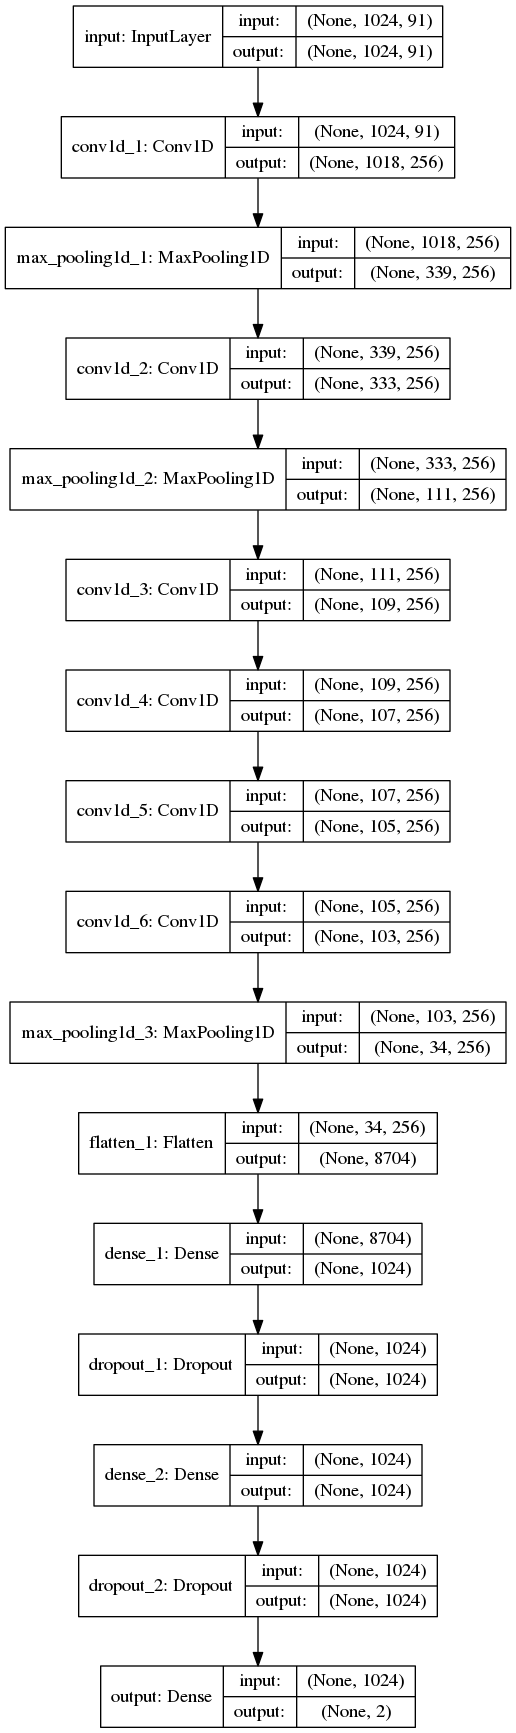

In [41]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

Image(model_to_dot(model, show_shapes=True).create(prog='dot', format='png'))

In [39]:
## saving plot model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='modelhh.png')

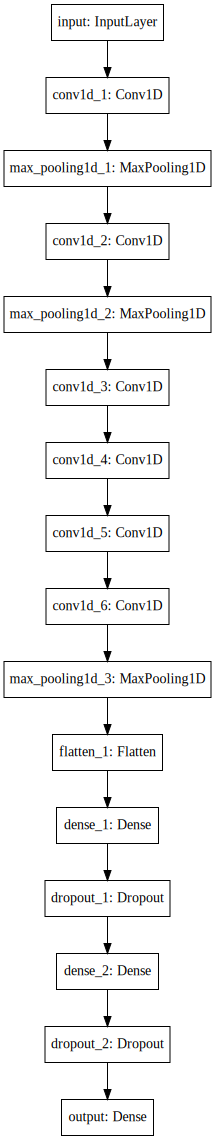

In [40]:
## showing model flow 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# import matplotlib.pyplot as plt

# history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()